$$ \color{red}{ ADD TITLE }$$

# Introduction

This post roughly corresponds to first part of Lecture 5 of UCL RL course by David Silver.

We will explore SARSA control algorithm and its extensions. Instead of just presenting algorithm, we will build it from scratch step by step.

Table of contents:
* Intro
  * [Introduction](#Introduction) - this section
  * [1D Corridor](#1D-Corridor) - update of toy environment from [previous post](../Lecture03/ModelFreePrediction_Part2.ipynb)
  * [Helper Functions](#Helper-Functions) - plotting etc.
* Monte-Carlo
  * [MC Prediction](#MC-Prediction) - Q version of MC prediction
  * [MC Control](#MC-Control) - MC prediction + e-greedy policy improvement
* On-Policy Control
  * [TD Prediction](#TD-Prediction) - Q version of TD(0) prediction
  * [SARSA](#SARSA) - TD(0) + e-greedy policy improvement = standard SARSA
  * [N-Step SARSA](#N-Step-SARSA) - n-step version of standard SARSA
* Off-Policy Control
  * [Expected SARSA](#Expected-SARSA) - off-policy version of standard SARSA using expectations (and n-step extension)
  * [Importance Sampling SARSA](#Importance-Sampling-SARSA) - off-policy SARSA using importance sampling (and n-step extensions, aka tree backup)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# 1D Corridor

In [272]:
class LinearEnv:
    """
    Allowed states are:
    State id: [ 0 ... 10 ... 20 ]
    Type:     [ T ...  S ...  T ]
    Reward:   [-1  0   0  0   1 ]
    """
    def __init__(self):
        size = 9
        self._max_left = 1      # last non-terminal state to the left
        self._max_right = size  # last non-terminal state to the right
        self._start_state = 0  # (size // 2) + 1
        self.reset()

    def reset(self):
        self._state = self._start_state
        self._done = False
        return self._state

    def step(self, action):
        if self._done: return (self._state, 0, True)  # We are done
        if action not in [0, 1]: raise ValueError('Invalid action')

        self._state += -1 if action==0 else 1
        self._state = max(self._state, 0)
        obs = self._state
        if self._state > self._max_right:
            reward = 0
            self._done = True
        elif self._state < self._max_left:
            reward = -1                     # reward -1
            self._done = False
        else:
            reward = -1                     # reward -1
            self._done = False
        if obs < 0:
            print('fjdksaljf klasjfdlkasjfdlkas')
        return (obs, reward, self._done)

In [152]:
# Correct Q values for [0.50, 0.50] policy
# Obtined by running MC for 100k episodes
REF_RANDOM = np.array([[-110.07463556, -108.1233054 ],
                       [-110.09031682, -104.09485386],
                       [-107.94742117,  -98.00252151],
                       [-103.72284066,  -89.93750735],
                       [ -97.63323972,  -79.91458033],
                       [ -89.75222013,  -68.08689526],
                       [ -79.99838449,  -54.46861147],
                       [ -68.49298885,  -38.1649777 ],
                       [ -54.15328992,  -20.27611015],
                       [ -38.32174908,    0.        ],
                       [   0.        ,    0.        ]])

# Correct Q values for [0.45, 0.55] left/right policy
# Obtined by running MC for 100k episodes
REF_SKEWED = np.array([[-60.99476087, -59.09055851],
                       [-60.77908483, -55.76384557],
                       [-58.89819709, -51.22998804],
                       [-55.73772496, -45.63866732],
                       [-50.97222381, -39.33574196],
                       [-45.39301033, -32.24870505],
                       [-38.95687197, -24.66562689],
                       [-31.77168208, -17.0898723 ],
                       [-25.04782432,  -8.64685428],
                       [-16.74904561,   0.        ],
                       [  0.        ,   0.        ]])

# Correct Q values for [0.00, 1.00] greedy policy
REF_GREEDY = np.array([[-10.,  -9.],
                       [-10.,  -8.],
                       [ -9.,  -7.],
                       [ -8.,  -6.],
                       [ -7.,  -5.],
                       [ -6.,  -4.],
                       [ -5.,  -3.],
                       [ -4.,  -2.],
                       [ -3.,  -1.],
                       [ -2.,   0.],
                       [  0.,   0.]])

In [229]:
env = LinearEnv()
obs_shape = [11]

pi_random = np.tile([0.50, 0.50], [11, 1])  # target random policy
pi_skewed = np.tile([0.45, 0.55], [11, 1])  # our behavioural policy
pi_greedy = np.tile([0.00, 1.00], [11, 1])  # target greedy policy

# Helper Functions

In [279]:
def generate_episode(policy):
    """Generate one complete episode"""
    trajectory = []
    done = True
    for _ in range(1000):  # limit episode length
        # === time step starts ===
        if done:
            obs, reward, done = env.reset(), None, False
        else:
            obs, reward, done = env.step(action)   
        action = np.random.choice([0, 1], p=policy[obs])
        trajectory.append((obs, reward, done, action))
        if done:
            break
        # === time step ends here ===
    else:
        print('HOLY COW!')
    return trajectory

In [346]:
def plot_q_hist(histories, truth_ref, plot_title):
    fig = plt.figure(figsize=[18,6])
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # ax1.plot(GROUND_TRUTH[1:-1], color='gray')
    ax1.plot(REF_RANDOM[:-1,0], color='gray')
    ax1.plot(REF_RANDOM[:-1,1], color='gray')
    ax1.plot(REF_SKEWED[:-1,0], color='gray')
    ax1.plot(REF_SKEWED[:-1,1], color='gray')
    ax1.plot(REF_GREEDY[:-1,0], color='gray')
    ax1.plot(REF_GREEDY[:-1,1], color='gray')
    for hist in histories:
        Q_vals = hist[-1]
        E_vals = np.sum(np.sum((truth_ref - hist)**2, axis=-1), axis=-1)
        
        ax1.plot(Q_vals[:-1,0], color='red', alpha=0.8)   # Q left
        ax1.plot(Q_vals[:-1,1], color='green', alpha=0.8) # Q right
        ax2.plot(E_vals, color='blue', alpha=0.8)

    ax1.grid()
    ax1.set_title('Estimated State-Values')
    ax2.grid()
    ax2.set_title('Ground Truth Error')
    fig.suptitle(title, fontsize=32)
    
    plt.show()

# Incremental Monte-Carlo

Estabilish reference data

In [157]:
def mc_experiment(N, policy):
    hist = []
    C = np.zeros(obs_shape)   # count state visits (see note #1)
    V = np.zeros(obs_shape)   # state-values
    C = np.zeros(shape=[*obs_shape, 2])
    Q = np.zeros(shape=[*obs_shape, 2])

    for ep in range(N):
        trajectory = generate_episode(policy)
        for i in range(len(trajectory)-1):
            Gt = sum([trajectory[j][1] for j in range(i+1, len(trajectory))])  # disc == 1
            St, _, _, At = trajectory[i]
            
            C[St] += 1
            # V[St] = V[St] + (1/C[St]) * (Gt - V[St])
            Q[St, At] = Q[St, At] + (1/C[St, At]) * (Gt - Q[St, At])
            
        hist.append(Q.copy())
        if ep % 1000 == 0:
            print('.', end='')

    return np.array(hist)

.HOLY COW!


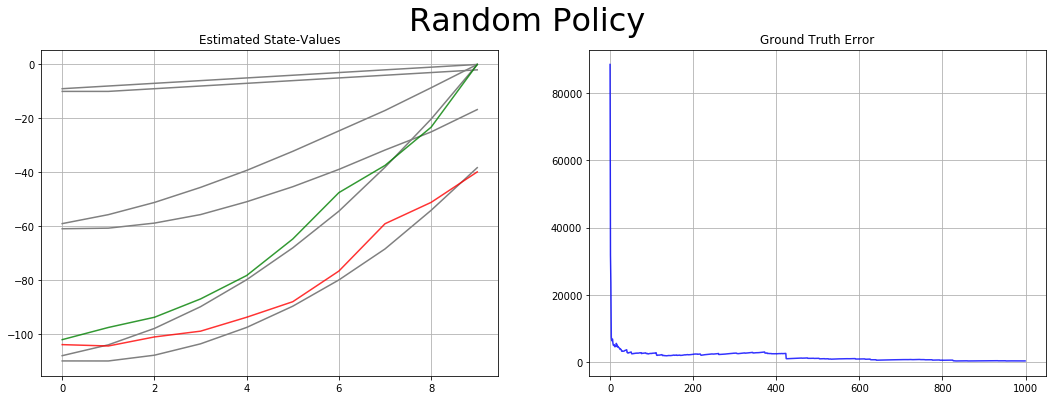

In [281]:
hist = mc_experiment(N=1000, policy=pi_random)
plot_q_hist([hist], 'Random Policy', REF_RANDOM)

.

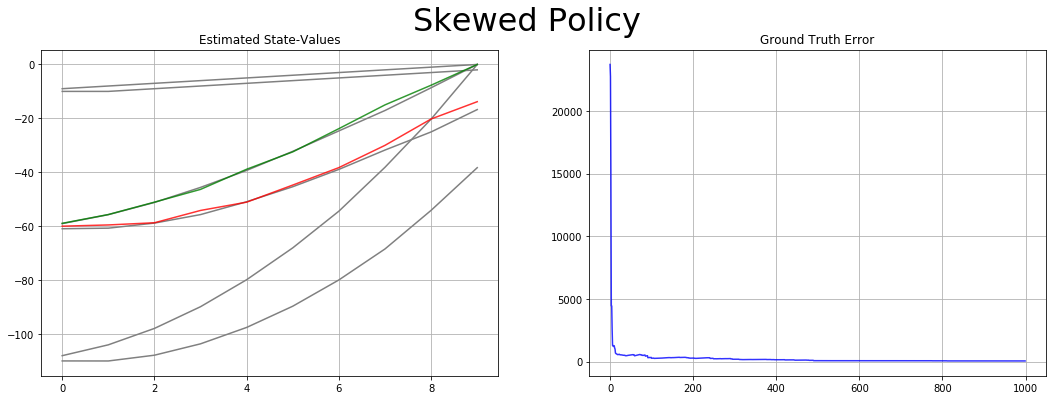

In [277]:
hist = mc_experiment(N=1000, policy=pi_skewed)
plot_q_hist('Skewed Policy', [hist], REF_SKEWED)

.

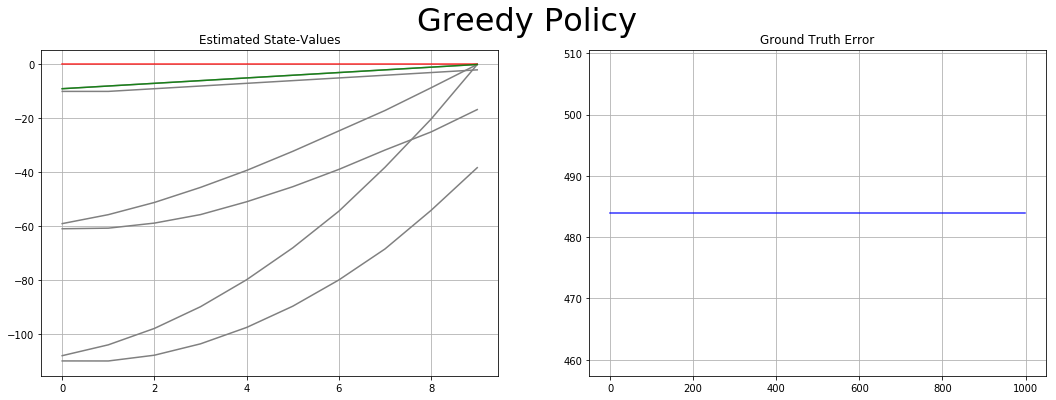

In [278]:
hist = mc_experiment(N=1000, policy=pi_greedy)
plot_q_hist('Greedy Policy', [hist], REF_GREEDY)

# TD(0) - On Policy

In [198]:
def td0_experiment(N, alpha, policy):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

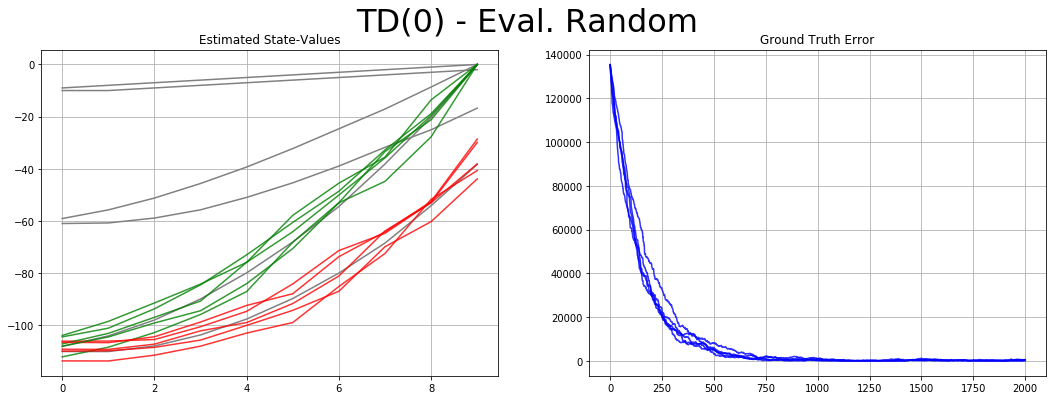

In [203]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_random)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Random', histories, REF_RANDOM)

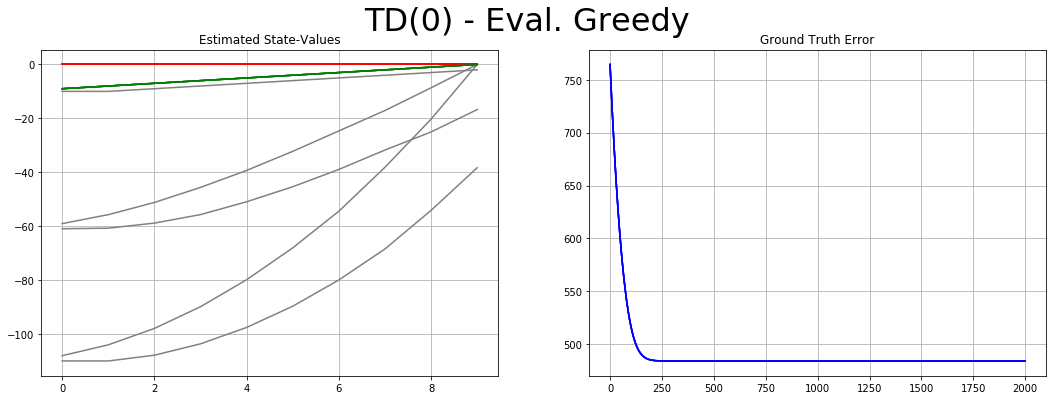

In [204]:
histories = []
for _ in range(5):
    hist = td0_experiment(N=2000, alpha=0.05, policy=pi_greedy)
    histories.append(hist)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)

### SARSA

$$ \color{red}{ TODO: tidy code! \\ remove \ holy \ cow} $$

In [292]:
def make_eps_greedy(Q, policy, eps):
    policy *= 0
    policy += eps
    maxq = np.argmax(Q, axis=-1)
    policy[range(len(policy)),maxq] = 1-eps
    
def sarsa_experiment(N, alpha, policy):
    hist, perf = [], []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = Rt_1 + 1.0*Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        make_eps_greedy(Q, policy, 0.15)
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!


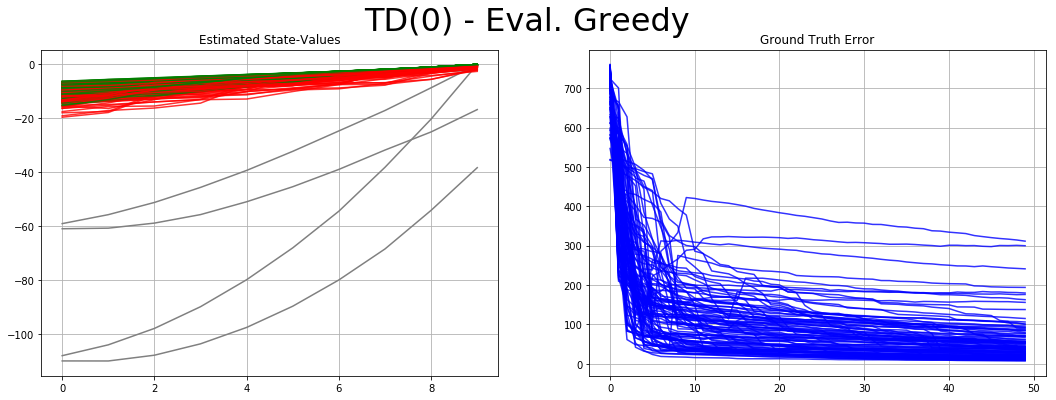

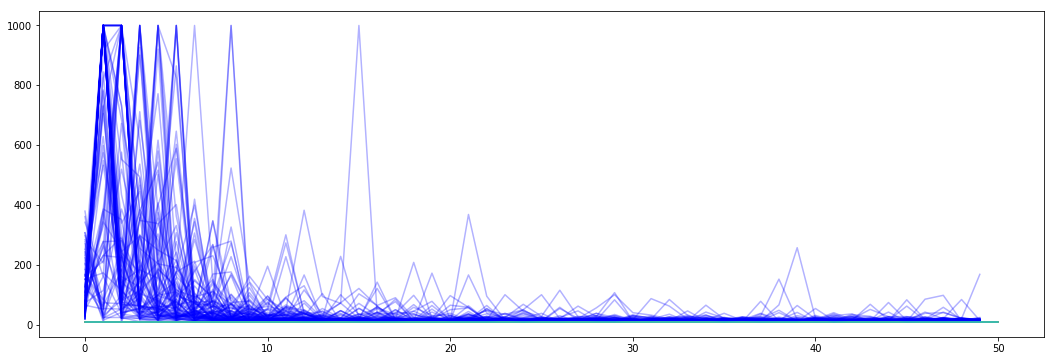

In [341]:
histories, performances = [], []
for _ in range(100):
    hist, perf = sarsa_experiment(N=50, alpha=0.05, policy=pi_random.copy())
    histories.append(hist)
    performances.append(perf)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)
fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(111)
for perf in performances:
    ax1.plot(perf, color='blue', alpha=0.3)
    ax1.plot([0, len(perf)],[10,10])

In [284]:
print(perf)
print(np.argmax(hist[-1], axis=-1))

[  78 1000 1000 1000  737 1000  134   89   93  421  226   47  297   87
   57   11   13   13   11   15   11   13   11   11   13   11   11   11
   13   16   11   11   11   13   11   13   13   11   11   11   11   11
   13   13   11   13   11   11   11   11   13   11   13   11   11   13
   14   13   11   13   15   11   11   15   12   11   13   11   11   11
   13   11   11   11   11   11   11   15   11   15   13   13   13   11
   11   11   13   11   13   13   11   13   15   11   11   11   13   11
   19   11]
[1 1 1 1 1 1 1 1 1 1 0]


### N-Step SARSA

In [296]:
def calc_Gt(trajectory, Q, t, disc, nstep=float('inf')):
    """Calculates return for state t, using n future steps.
    Params:
        traj - complete trajectory, each time-step should be tuple:
            (observation, reward, done, action)
        Q (float arr) - state-action-values, Q[term_state,:] must be zero!
        t (int [t, T-1]) - calc Gt for this time step in trajectory,
            0 is initial state; T-1 is last non-terminal state
        disc - discrount, usually noted as gamma
        n (int or +inf, [1, +inf]) - n-steps of reward to accumulate
                If n >= T then calculate full return for state t
                For n == 1 this equals to TD return
                For n == +inf this equals to MC return
    """

    T = len(trajectory)-1   # terminal state
    max_j = min(t+nstep, T) # last state iterated, inclusive
    tmp_disc = 1.0          # this will decay with rate disc
    Gt = 0                  # result

    # Iterate from t+1 to t+nstep or T (inclusive on both start and finish)
    for j in range(t+1, max_j+1):
        Rj = trajectory[j][1]  # traj[j] is (obs, reward, done, action)
        Gt += tmp_disc * Rj
        tmp_disc *= disc

    # Note that Q[Sj, Aj] will have state-value of state t+nstep or
    # zero if t+nstep >= T as V[St=T] must equal 0
    Sj, _, _, Aj = trajectory[j]  # traj[j] is (obs, reward, done, action)
    Gt += tmp_disc * Q[Sj, Aj]

    return Gt

In [344]:
def nstep_sarsa_experiment(N, alpha, policy):
    hist, perf = [], []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(policy)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            Gt = calc_Gt(trajectory, Q, t, disc=1.0, nstep=2)
            target = Gt
            Q[St, At] = Q[St, At] + alpha * (target - Q[St, At])
        make_eps_greedy(Q, policy, 0.15)
        hist.append(Q.copy())
        perf.append(len(trajectory))
        
    return np.array(hist), np.array(perf)

HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!
HOLY COW!


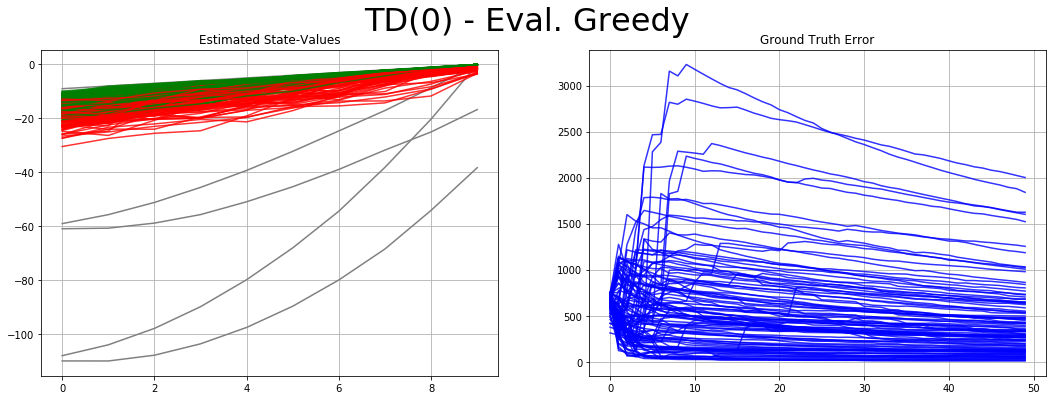

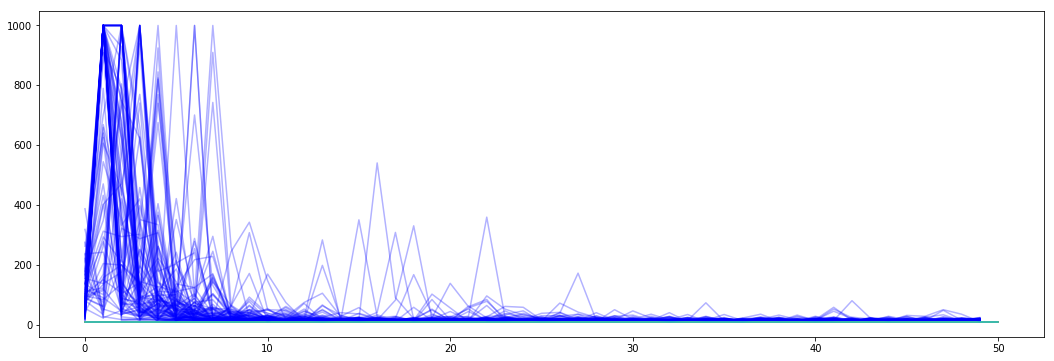

In [345]:
histories, performances = [], []
for _ in range(100):
    hist, perf = nstep_sarsa_experiment(N=50, alpha=0.05, policy=pi_random.copy())
    histories.append(hist)
    performances.append(perf)
plot_experiments('TD(0) - Eval. Greedy', histories, REF_GREEDY)
fig = plt.figure(figsize=[18,6])
ax1 = fig.add_subplot(111)
for perf in performances:
    ax1.plot(perf, color='blue', alpha=0.3)
    ax1.plot([0, len(perf)],[10,10])

# TD(0) - with Expected Return

In [205]:
def exp_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            # target = Q[St_1, At_1]  # sarsa
            target = pol_tar[St, 0]*Q[St_1, 0] + pol_tar[St, 1]*Q[St_1, 1]  # exp sarsa
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

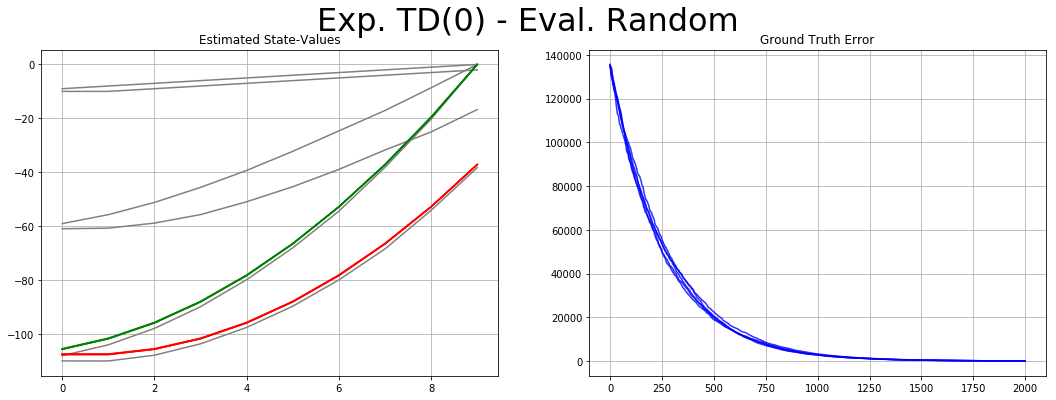

In [206]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Random', histories, REF_RANDOM)

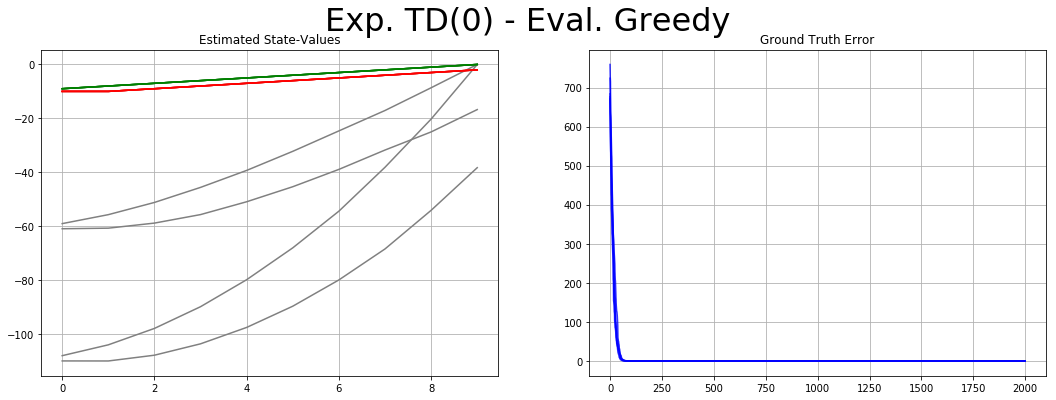

In [207]:
histories = []
for _ in range(5):
    hist = exp_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('Exp. TD(0) - Eval. Greedy', histories, REF_GREEDY)

# TD(0) with Importance Sampling

In [208]:
def is_td0_experiment(N, alpha, pol_beh, pol_tar):
    hist = []
    Q = np.zeros(shape=[*obs_shape, 2])
    for ep in range(N):
        trajectory = generate_episode(pol_beh)
        for t in range(len(trajectory)-1):
            St, _, _, At = trajectory[t]
            St_1, Rt_1, _, At_1 = trajectory[t+1]
            target = (pol_tar[St, At] / pol_beh[St, At]) * Q[St_1, At_1]
            Q[St, At] = Q[St, At] + alpha * (Rt_1 + 1.0*target - Q[St, At])
        hist.append(Q.copy())
    return np.array(hist)

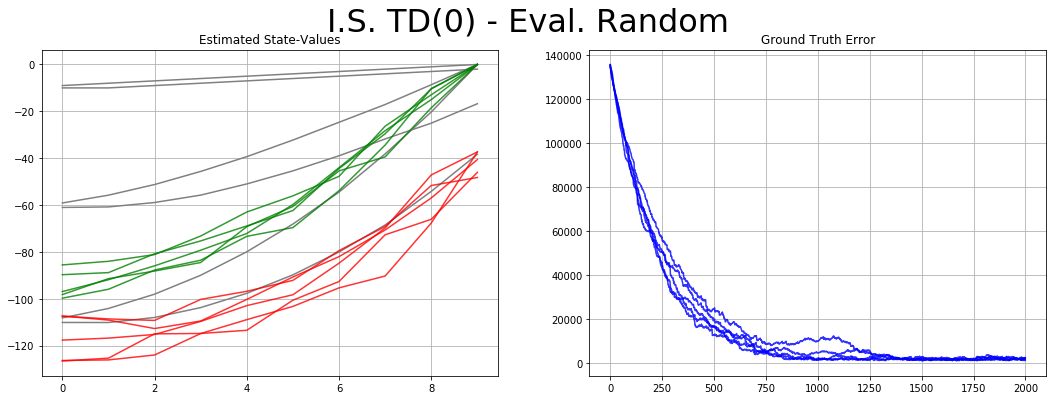

In [210]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_random)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Random', histories, REF_RANDOM)

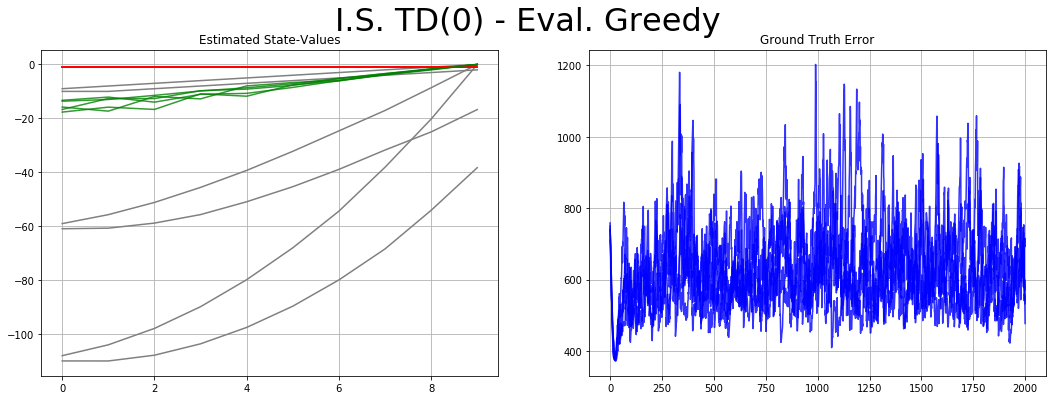

In [211]:
histories = []
for _ in range(5):
    hist = is_td0_experiment(N=2000, alpha=0.05, pol_beh=pi_skewed, pol_tar=pi_greedy)
    histories.append(hist)
plot_experiments('I.S. TD(0) - Eval. Greedy', histories, REF_GREEDY)